
# Probabilistic Tsunami Hazard Assessment (PTHA) Scenario Reduction

This notebook explains and demonstrates how to reduce a large number of tsunami
scenarios (generated from Karhunen–Loève (K-L) expansion) into a smaller set of
representative scenarios using **Weighted K-means clustering**.

---

## Theory

- **Scenario Generation**: Earthquake slip distributions are generated using
  K-L expansion. Each scenario is represented by coefficients in the K-L basis.

- **Scenario Probabilities**: Each scenario has an associated probability weight
  (from the statistical slip model).

- **Problem**: Running full tsunami simulations for thousands of scenarios is
  computationally expensive.

- **Solution**: Cluster scenarios in K-L space with probabilities taken into
  account, and select representative scenarios (cluster centroids) with new
  weights.

### Why Weighted K-means?
- Standard K-means ignores scenario probabilities.
- Weighted K-means incorporates them, ensuring high-probability scenarios
  influence the clustering more strongly.
- The output is a reduced set of scenarios that still represents the probability
  distribution well.

---

## Workflow

1. Load `scenario_pts.txt` (K-L coefficients of scenarios).
2. Load `scenario_prb_wgts.txt` (probability weights).
3. Normalize weights so they sum to 1.
4. Apply Weighted K-means clustering to select representative centroids.
5. Assign new cluster weights by summing original scenario weights in each cluster.
6. Visualize results (PCA scatter plot and bar chart of cluster weights).
7. Export reduced scenarios with weights to CSV for further tsunami simulations.


In [4]:

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Load scenario data
pts = np.loadtxt("scenario_pts.txt")
wgts = np.loadtxt("scenario_prb_wgts_new.txt")

# Normalize weights to sum to 1
wgts = wgts / np.sum(wgts)

print("Scenarios shape:", pts.shape)
print("Weights shape:", wgts.shape)


Scenarios shape: (100, 20)
Weights shape: (100,)


In [5]:

# Number of representative clusters (synthetic centroids)
k = 20

# Run Weighted K-means clustering
model = KMeans(n_clusters=k, random_state=42)
model.fit(pts, sample_weight=wgts)

# Get cluster centroids (representative scenarios)
centroids = model.cluster_centers_

# Assign each scenario to nearest centroid
labels = model.predict(pts)

# Compute new cluster weights = sum of member weights
cluster_wgts = np.array([wgts[labels == i].sum() for i in range(k)])

# Prepare results
results_df = pd.DataFrame(centroids, columns=[f"KL_mode_{i+1}" for i in range(pts.shape[1])])
results_df["Cluster_Weight"] = cluster_wgts
results_df.head()


,KL_mode_1,KL_mode_2,KL_mode_3,KL_mode_4,KL_mode_5,KL_mode_6,KL_mode_7,KL_mode_8,KL_mode_9,KL_mode_10,...,KL_mode_12,KL_mode_13,KL_mode_14,KL_mode_15,KL_mode_16,KL_mode_17,KL_mode_18,KL_mode_19,KL_mode_20,Cluster_Weight
0,-1.782540,-1.121950,0.869217,1.134703,-2.638621,1.101899,-2.495693,0.270497,-4.163997,1.637823,...,1.557592,0.558320,1.349135,0.481305,-0.037453,-0.721175,-0.595983,-1.670077,-2.012853,0.092296
1,-1.083579,0.182372,0.681010,2.401493,-2.476287,-0.974664,0.527760,0.298170,1.438044,-3.396762,...,2.726846,0.954411,-0.206349,-2.734865,-3.417363,1.130315,1.753070,0.411098,0.921213,0.197017
2,3.415284,1.610948,-0.453199,1.132335,-2.130395,0.609267,-0.366138,-1.016493,-3.606030,0.151734,...,-0.493516,1.210747,1.469954,0.799382,2.488807,-0.941528,0.674294,3.457592,-0.338817,0.147043
3,1.527426,-4.608970,2.116372,1.817094,1.307678,-1.245572,0.810830,-1.258490,-1.121383,-1.799029,...,-1.543793,-2.072073,0.388800,-1.168366,0.511560,-0.445907,1.943606,2.533853,-1.094295,0.092884
4,2.325911,-1.282977,-1.809376,-0.639898,1.337858,-0.860104,2.321756,1.413289,-3.713276,1.003096,...,1.482681,0.478737,-3.570594,-1.005538,2.629701,0.163389,-0.386736,-1.614896,0.086244,0.038777


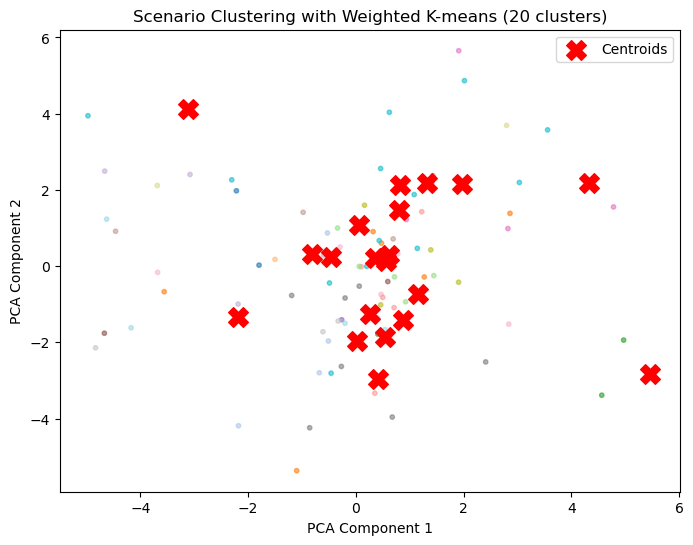

In [6]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization (2D)
pca = PCA(n_components=2)
pts_2d = pca.fit_transform(pts)
centroids_2d = pca.transform(model.cluster_centers_)

# Plot scenarios colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pts_2d[:, 0], pts_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.6)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c="red", marker="X", s=200, label="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Scenario Clustering with Weighted K-means (20 clusters)")
plt.legend()
plt.show()


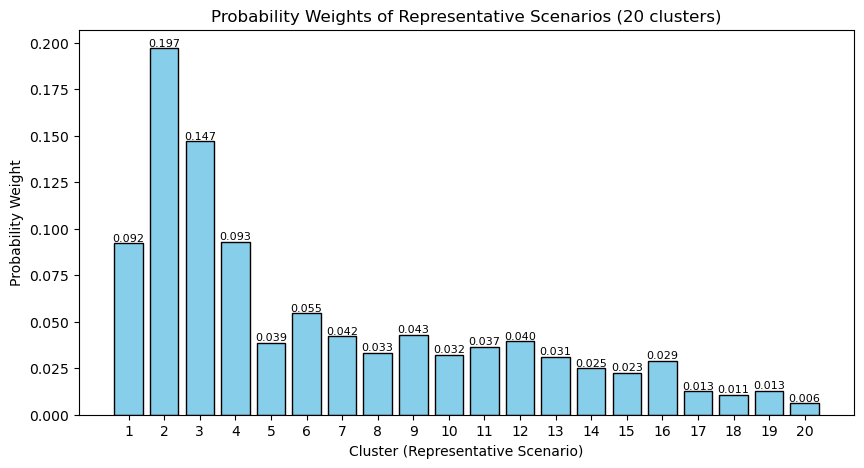

In [7]:

# Bar chart of cluster weights
plt.figure(figsize=(10, 5))
bars = plt.bar(range(1, k+1), cluster_wgts, color="skyblue", edgecolor="black")
plt.xlabel("Cluster (Representative Scenario)")
plt.ylabel("Probability Weight")
plt.title("Probability Weights of Representative Scenarios (20 clusters)")
plt.xticks(range(1, k+1))

# Annotate weights on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.3f}",
             ha='center', va='bottom', fontsize=8)

plt.show()


In [8]:

# Save representative centroids and weights to CSV
output_csv = "reduced_scenarios.csv"
results_df.to_csv(output_csv, index=False)
print(f"Reduced scenarios saved to {output_csv}")


Reduced scenarios saved to reduced_scenarios.csv
